In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process
import easyocr

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *
from ReadDate import *
from featurematching import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

c:\Users\fhacesga\Anaconda3\envs\yolo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\fhacesga\AppData\Local\Temp\ipykernel_15956\1811205482.py:17: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. 

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [3]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\uncompress_2\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
    tiled_yolo_model_paths = [
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
    ]
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

In [4]:
proc_dir = r"D:\480296_gen\\"

For each image we are processing, identify street corners

In [5]:
tiles = glob.glob(proc_dir + "referencing\*.tif")

out = processTiledYOLOs(tiles, tiled_yolo_model_paths, ['CornerCoordinates', 'street_corners'], proc_dir, imsizes=[256, 320])

cornercoords_dict = out[0]
streetcorner_dict = out[1]

Making images half size for tiled inference


  0%|          | 0/37 [00:00<?, ?it/s]

Reading from D:\480296_gen\\CornerCoordinates.pkl
Reading from D:\480296_gen\\street_corners.pkl


In [6]:
corners     = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf   = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

In [7]:
corner_dir = os.path.join(get_largest_subdirectory(os.path.join(proc_dir, "street_corners")), "pickles")

if os.path.isdir(os.path.join(proc_dir, "focus")):
    referencing_dir  =  os.path.join(proc_dir, "focus") + "\\"
    print(f"Focus found, using {referencing_dir}")

registration_dir = os.path.join(proc_dir, "registration")
os.makedirs(registration_dir, exist_ok=True)

print(corner_dir)

D:\480296_gen\\street_corners\exp\pickles


In [8]:
np.set_printoptions(precision=8) 

In [9]:
def normCoords(A, B):
    offsets = np.min(A, axis=0)
    return A - offsets, B - offsets

def updateResults(list1, list2, verbose=False):
    combined_dict = {}
    all_matches = list1 + list2

    if not all_matches:
        return []

    # Check data format (tuple vs dict)
    is_dict_format = isinstance(all_matches[0], dict)

    for entry in all_matches:
        if is_dict_format:
            key = entry["real_idx"]
            d1, d2 = entry["d1"], entry["d2"]
        else:
            key = entry[0]
            d1, d2 = entry[2], entry[3]

        try:
            current_ratio = d1 / d2
        except ZeroDivisionError:
            continue

        if key not in combined_dict:
            combined_dict[key] = entry
        else:
            prev = combined_dict[key]
            prev_ratio = (prev["d1"] / prev["d2"]) if is_dict_format else (prev[2] / prev[3])
            if current_ratio < prev_ratio:
                combined_dict[key] = entry

    combined_list = list(combined_dict.values())
    if verbose:
        print("Results Update:", len(list1), len(list2), len(combined_list))
    return combined_list
def most_popular_indices_2d_flexible(uv_vectors, eps=0.1, iteration=0, n_iters=10, min_cluster_size=10):
    """
    uv_vectors: np.ndarray of shape (N, 2) representing delta vectors (dx, dy)
    eps: base clustering threshold (in normalized space)
    iteration: current iteration index (0-based)
    n_iters: total iterations expected
    """
    # Compute angle and magnitude
    angles = np.degrees(np.arctan2(uv_vectors[:, 1], uv_vectors[:, 0])) % 360
    magnitudes = np.linalg.norm(uv_vectors, axis=1)

    # Normalize
    angle_norm = angles / 360.0  # 0–1
    length_norm = magnitudes / (np.max(magnitudes) + 1e-6)

    # Decay angle weight as we get closer to convergence
    angle_weight = max(1 - (iteration / n_iters), 0.1)
    length_weight = 1.0

    combined = np.vstack([
        angle_norm * angle_weight,
        length_norm * length_weight
    ]).T

    db = DBSCAN(eps=eps, min_samples=2).fit(combined)
    labels, counts = np.unique(db.labels_[db.labels_ != -1], return_counts=True)

    if len(counts) == 0:
        return []

    # Keep all clusters with sufficient support
    good_clusters = [label for label, count in zip(labels, counts) if count >= min_cluster_size]

    indices = [i for i, label in enumerate(db.labels_) if label in good_clusters]
    return indices, combined

In [44]:
def plotMatchesNew(fromPoints, toPoints, angles, idx, coordsBPrime=None, add_basemap=True):
    """
    Plots original and matched points, their directional vectors, and angle histogram.
    `idx` should be the final filtered indices to highlight in yellow.
    """

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot all points
    fromPoints.plot(ax=axs[0],  color='red', markersize=5)
    toPoints.plot(ax=axs[0],    color='blue', markersize=5)

    # Full vector field
    axs[0], uv = calcQuiver(axs[0], fromPoints, toPoints, color="black")

    # Add basemap (optional)
    if add_basemap:
        try:
            cx.add_basemap(axs[0])
        except:
            print("Error adding Basemap")

    # Highlight final filtered matches
    axs[0], uv_filtered = calcQuiver(axs[0], fromPoints.iloc[idx], toPoints.iloc[idx], color="yellow")

    axs[0].scatter(coordsBPrime[:, 0], coordsBPrime[:, 1], marker='x', c='red', label='B warped')

    # Angle histograms
    bins = np.linspace(-180, 180, 100)
    axs[1].hist(angles, bins, label="All", alpha=0.5)
    axs[1].hist(angles[idx], bins, label="Filtered", color="orange", alpha=0.7)
    axs[1].set_xlabel("Adjustment Bearing (degrees)")
    axs[1].set_ylabel("Frequency (n)")
    axs[1].legend()

    return fig, axs


def addGCPsandIndices(coordsA, coordsB, idx, gcps, weights):
    if gcps is None:
        newA = coordsA[idx, :]
        newB = coordsB[idx, :]
        weights = weights[idx]
    else:
        newA = np.vstack((coordsA[idx, :], gcps[['image_X', 'image_Y']].to_numpy()))
        newB = np.vstack((coordsB[idx, :], gcps[['X', 'Y']].to_numpy()))
        gcp_weights = np.ones(len(gcps))  # assume equal confidence for GCPs
        weights = np.concatenate((weights[idx], gcp_weights))
        print(newA)
        print(newB)
    return newA, newB, weights

def adjustGCPs(gcps):
    coordsA = gcps[['image_X', 'image_Y']].to_numpy()
    coordsB = gcps[['X', 'Y']].to_numpy()
    initial = similarityTransformation(coordsA[:, 0], coordsA[:, 1], coordsB[:, 0], coordsB[:, 1],verbose=False)
    matrix = initial.matrix
    coordsBprime = np.hstack((coordsB, np.ones((coordsB.shape[0], 1)))) @ np.linalg.inv(matrix).T    
    coordsAprime = np.hstack((coordsA, np.ones((coordsA.shape[0], 1)))) @ matrix.T    

    distances = np.sqrt((coordsBprime[:, 0] - coordsA[:, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[:, 1]) ** 2)
    print(distances)
    return matrix, distances, distances > -10000

def apply_adjustment_to_gdf(gdf, matrix, idx=None):
    """Apply 3×3 affine (homogeneous) matrix M to a subset of a GeoDataFrame and return only adjusted rows with all fields preserved."""
    cord_arry = getCoordsGDF(gdf)
    if idx is None:
        idx = np.arange(cord_arry.shape[0])

    cord_arry = np.hstack((cord_arry[idx], np.ones((len(idx), 1))))
    xy1_t = cord_arry @ matrix.T

    # Extract and transform only selected rows
    gdf_subset = gdf.iloc[idx].copy()
    gdf_subset['geometry'] = gpd.points_from_xy(xy1_t[:, 0], xy1_t[:, 1])

    return gdf_subset

def extract_weights(matchresults, q_weight=0.4, o_weight=0.3, l_weight=0.3):
    """
    Extracts match weights from matchresults list.
    Uses quality tuple (q, o, l) if available, otherwise returns weight=1.
    """
    weights = []
    for m in matchresults:
        if isinstance(m, dict) and "qualities" in m:
            q, o, l = m["qualities"]
            weight = (q_weight * q) + (o_weight * o) + (l_weight * l)
        else:
            weight = 1.0
        weights.append(weight)
    return np.array(weights, dtype=np.float32)


def adjustFromMatchingV4(matchresults, 
                         idx=None, 
                         plot=False, 
                         verbose=False, 
                         dbscan_eps=0.04, 
                         logging_dir=None, 
                         iteration_struct=(0, 10),
                         n_internal_passes=10,
                         filter_topn=None, 
                         distance_thresh=None,
                         gcps=None):
    
    # Optional confidence filtering
    if filter_topn is not None:
        print(f"Filtering top {filter_topn}")
        conf = [a[8][0] / a[8][1] for a in matchresults]
        indices = np.argsort(conf)[:filter_topn]
        matchresults = [matchresults[i] for i in indices]

    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)

    if isinstance(matchresults[0], dict):
        image_coords = [x["image_coords"] for x in matchresults]
        real_coords  = [x["real_coords"]  for x in matchresults]
    else:
        image_coords = [x[5] for x in matchresults]
        real_coords  = [x[4] for x in matchresults]

    weights=extract_weights(matchresults)

    fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
        [pt[0] for pt in image_coords], [pt[1] for pt in image_coords]))
    toPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
        [pt[0] for pt in real_coords], [pt[1] for pt in real_coords]))

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    # Iterative refinement loop
    i, checker = 0, True
    prev_len = len(idx)

    while checker and i < n_internal_passes:
        # Re-inject GCPs each round and do index slicing
        coordsA_aug, coordsB_aug, weights = addGCPsandIndices(coordsA, coordsB, idx, gcps, weights)

        # Estimate similarity transform FROM image TO real
        transform = similarityTransformation(
            coordsA_aug[:, 0], coordsA_aug[:, 1],
            coordsB_aug[:, 0], coordsB_aug[:, 1],
            verbose=False, rotation_limit=3, weights=weights             
        )

        matrix = transform.matrix

        # Transform image to real
        reprojectedpoints   = getCoordsGDF(apply_adjustment_to_gdf(fromPoints, matrix, idx=idx))
        distances           = np.linalg.norm(reprojectedpoints[:, :2] - coordsB[idx], axis=1)

        # reprojectedpoints_oldfashioned = np.hstack((coordsA[idx], np.ones((len(idx), 1)))) @ matrix.T
        # distances_oldfashioned = np.linalg.norm(reprojectedpoints_oldfashioned[:, :2] - coordsB[idx], axis=1)

        # Compute angular and magnitude features (FROM IMAGE TO REAL)
        uv = coordsA - coordsB
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        magnitudes = np.sqrt(uv[:, 0] ** 2 + uv[:, 1] ** 2)
        test = np.vstack((normArry(angles), normArry(magnitudes))).T
        test[np.isnan(test)] = 0

        # DBSCAN-based filtering
        db_idx, current_values = most_popular_indices_2d_flexible(
            test, eps=dbscan_eps, iteration=iteration_struct[0], n_iters=iteration_struct[1])

        # Distance-based filtering
        dist_thresh = 3 * np.median(distances)
        dist_idx = np.where(distances <= dist_thresh)[0]

        print("IDX",np.where(idx)[0].shape[0])
        print("DISTNACE", np.where(dist_idx)[0].shape[0])
        print("DBSCAN", np.where(db_idx)[0].shape[0])

        # Combine filters
        idx = np.intersect1d(np.intersect1d(idx, dist_idx), db_idx)
        print("INTERSECT", np.where(idx)[0].shape[0])

        print(len(idx))
        print(idx)

        # Relax filter if too few remain
        if len(idx) < 10:
            print("Loosening DBSCAN... ", end="")
            for j in range(1, 11):
                temp_idx, current_values = most_popular_indices_2d_flexible(
                    test, eps=dbscan_eps + 0.02 * j,
                    iteration=iteration_struct[0], n_iters=iteration_struct[1])
                if len(temp_idx) >= 10:
                    idx = np.intersect1d(idx, temp_idx)
                    print(f"Loosened to eps={dbscan_eps + 0.02 * j}")
                    break

        # Stop if convergence
        if len(idx) >= prev_len:
            checker = False
        else:
            prev_len = len(idx)

        # Optional debug plot
        if verbose:
            print(f"Iteration {i}, matrix:\n{np.linalg.inv(matrix).T}")
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], c='black', label='A')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1], c='blue', label='B')
            axs[0].scatter(reprojectedpoints[:, 0], reprojectedpoints[:, 1], marker='x', c='red', label='B warped')
            axs[0].legend()
            axs[1].hist(distances, bins=50)
            axs[1].set_title(f"Residuals (iter {i})")
            fig.savefig(logging_dir[:-3] + f"_iteration{i}.jpg")
            if not plot:
                plt.close(fig)
            else:
                plt.show()

        i += 1

    if len(idx) == 0:
        print(f"DBSCAN FILTER FAILED. FALLING BACK ON ALL POINTS.")
        idx = np.arange(len(matchresults), dtype=np.int32)
        coordsA = getCoordsGDF(fromPoints)
        coordsB = getCoordsGDF(toPoints)
        coordsA_aug, coordsB_aug, weights = addGCPsandIndices(coordsA, coordsB, idx, gcps, weights)

        # Transform image to real
        reprojectedpoints   = getCoordsGDF(apply_adjustment_to_gdf(fromPoints, matrix, idx=idx))
        distances           = np.linalg.norm(reprojectedpoints[:, :2] - coordsB[idx], axis=1)

        # Estimate similarity transform FROM image TO real
        transform = similarityTransformation(
            coordsA_aug[:, 0], coordsA_aug[:, 1],
            coordsB_aug[:, 0], coordsB_aug[:, 1],
            verbose=False, rotation_limit=3, weights=weights             
        )

        matrix = transform.matrix

        return matrix, distances, idx, None

    # Final distance threshold (optional)
    if distance_thresh is not None and 'distances' in locals():
        n_before_dfilt = distances.shape[0]
        distances = distances[idx]
        idx = idx[distances < distance_thresh]
        distances = distances[distances < distance_thresh]
        if verbose:
            print(f"DISTANCE THRESHOLD REMOVED {n_before_dfilt - distances.shape[0]}")
    
    # Optional initial plot
    if logging_dir is not None and 'angles' in locals():
        fig, axs = plotMatchesNew(fromPoints, toPoints, angles, idx, coordsBPrime=reprojectedpoints)
        fig.savefig(logging_dir)
        if not plot:
            plt.close(fig)
        else:
            plt.show()

    return matrix, distances, idx, current_values

def registerImagesV3(group_name, im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds, 
                     r_initial=500, 
                     r_min=300,
                     verbose=1, 
                     distance_threshold=10,
                     n_iters=20,
                     r_change=0.6,
                     ratio_threshold=0.9,
                     dbscan_ini=0.04,
                     dbscan_max=0.1,
                     gcps=None,
                     logging_dir=None,
                     n_internal_passes=10,
                     remove_stdev=True
                     ):
    
    compoundedAdjustment = np.eye(3)
    
    os.makedirs(logging_dir, exist_ok=True)
    logging_basename = os.path.join(logging_dir, group_name)

    matching_results = None
    im_corner_gdf_adj = im_corner_gdf.copy()
    im_corner_gdf_adj['orig_x'] = im_corner_gdf_adj.geometry.x
    im_corner_gdf_adj['orig_y'] = im_corner_gdf_adj.geometry.y

    registration_struct = {}
    registration_struct['best_grade']       = 1e9
    registration_struct['grades']           = []
    registration_struct['transforms']       = []
    registration_struct['points']           = []

    for i in range(n_iters):
        
        r_current = r_initial * r_change ** i
        dbscan_curr = dbscan_ini + dbscan_ini * i
        
        dbscan_curr = min(dbscan_curr, dbscan_max)
        r_current   = max(r_current, r_min)

        # MAIN P1
        print("Enter Matching")
        matching_results_curr, im_corner_gdf_adj, _ = matching_distances_loosen_distance(im_corner_gdf_adj, corners_curr, 
                                                                    ratio_threshold=ratio_threshold, 
                                                                    match_radius=r_current, 
                                                                    num_retries=10,
                                                                    loosening_factor=0.25,
                                                                    quality_weight=0.5, 
                                                                    **descriptor_kwds)
        
        if matching_results is None:
            matching_results = matching_results_curr
        else:
            matching_results = updateResults(matching_results, matching_results_curr, verbose=verbose>3)
        
        print(len(matching_results))
        if len(matching_results) < 3:
            registration_struct[i] = {}
            registration_struct[i]["matching_results"]   = matching_results
            return None, registration_struct
        
        if i == 0 and gcps is not None:
            current_adjustment, distances, idx = adjustGCPs(gcps)
        else:
            # TODO: REMOVE DB_scan_values. They were for troubleshotting the unending filtering caused by repeated passes during fine tuning
            current_adjustment, distances, idx, DB_scan_values = adjustFromMatchingV4(matching_results, plot=verbose>8, 
                                                        dbscan_eps=dbscan_curr,
                                                        verbose=verbose>8,
                                                        gcps=gcps,
                                                        n_internal_passes=n_internal_passes,
                                                        distance_thresh=r_current,
                                                        iteration_struct = (i, n_iters),
                                                        logging_dir=None if logging_dir is None else logging_basename + f"_iteration{str(i).zfill(2)}.jpg")
        
            matching_results = [matching_results[i] for i in idx]


        im_corner_gdf_adj = apply_adjustment_to_gdf(im_corner_gdf_adj, current_adjustment)

        scale       = np.sqrt(0.5 * (current_adjustment[0,0] ** 2 + current_adjustment[1,1] ** 2))
        translation = np.sqrt(current_adjustment[0,2] ** 2 + current_adjustment[1,2] ** 2)

        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results), len(distances[distances<100]))

        if verbose > 3:
            print(f"Distances under 100: {distances[distances<100]}" )
            
        if verbose > 8:
            print(f"Scale {scale:.3e}")
            print(f"Translation {translation:.3e}")
        
        if verbose > 10: 
            print(current_adjustment)
            print("Inverse")
            print(np.linalg.inv(current_adjustment))

        # IF BEST, SAVE AS BEST
        if np.nanpercentile(distances, 50) < registration_struct['best_grade']:
            registration_struct['best_grade']             = np.nanpercentile(distances, 50)
            registration_struct['best_im_corner_gdf_adj'] = im_corner_gdf_adj

        # SAVE CURRENT TIMESTEP VALUES
        registration_struct[i] = {}
        registration_struct[i]['grade']     = np.nanpercentile(distances, 50)
        registration_struct[i]['adjust']    = current_adjustment
        registration_struct[i]['comp_adj']  = compoundedAdjustment
        registration_struct[i]["matching_results"]   = matching_results
        registration_struct[i]["distances"]          = distances
        registration_struct[i]["DB_scan_values"]     = DB_scan_values
        
        registration_struct['points'].append(im_corner_gdf_adj)
        registration_struct['grades'].append(np.nanpercentile(distances, 50))
        registration_struct['transforms'].append(current_adjustment)

        # CHECK IF WE HAVE ANY CONDITIONS FOR EARLY STOPPING
        matched_check = np.nanpercentile(distances, 50) < distance_threshold
        conv_check  = np.abs(1 - scale) < 0.002 and translation < distance_threshold

        if (matched_check or conv_check) and i > 1:
            print(matched_check, conv_check)
            break

    with open(logging_basename+".pkl", 'wb') as handle:
        pickle.dump(registration_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)       

    return registration_struct['best_im_corner_gdf_adj'], registration_struct


In [29]:

def loadGCPs(mydir, tile_dir, ra_ref):
    if os.path.exists(mydir):
        gcps_df = pd.read_csv(mydir)
        gdfs = []

        for i, tile in enumerate(tile_dir):
            curr_name = os.path.basename(tile).split(".")[0]
            curr_df   = gcps_df[gcps_df['ID'] == curr_name]
            curr_gdf = pointsToGeodataFrame(ra_ref[i], curr_df['row'].to_numpy(), curr_df['col'].to_numpy())
            gdfs.append(curr_gdf)
        
        
        a = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

        gcps_df['image_X'] = np.array([aa.x for aa in a['geometry']])
        gcps_df['image_Y'] = np.array([aa.y for aa in a['geometry']])
        return gcps_df
    else:
         return None
def getBBOX(im_file, RLNN):
    bounds, RLNN = findBounds(im_file, RLNN)

    # IF BOUNDS FOUND, USE. ELSE, USE IMAGE BOUNDS
    if len(bounds[0]) < 1:
        print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile_name}")
        bbox = [0, 0, image.shape[0], image.shape[1]]
        datebox = [ int(image.shape[1] * 0.75), int(image.shape[0] * 0.75), image.shape[1], image.shape[0]]
    else:
        bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
    return bbox, RLNN

def getTileCorners(tile_dir, ra_ref, conf_thresh=0.3, filter_by_bounding_box=True):

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")

    if len(corner_bbox) == 0:
        return None, None

    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)

    if filter_by_bounding_box:
        bbox, _ = getBBOX(tile_dir, None)
        corner_arry, corner_confs = cleanCenterBBOX(corner_arry, bbox, opt_return=[corner_confs])

    # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
    im_corner_gdf = pointsToGeodataFrame(ra_ref, corner_arry[:, 1], corner_arry[:, 0])
    return im_corner_gdf, corner_confs


def cornerConfsToDescriptorWeights(corner_confs):
    q99 = np.percentile(corner_confs, 99)
    return np.clip(corner_confs / q99, 0, 1)

def estimate_per_image_transforms(im_corner_gdf_adj):
    """Estimate similarity transforms per image from adjusted GDF."""
    transform_dict = {}

    grouped = im_corner_gdf_adj.groupby("source_image")

    for source_image, gdf in grouped:
        if len(gdf) < 3:
            print(f"Skipping {source_image}: not enough points.")
            continue
        
        coords_adj = getCoordsGDF(gdf)

        transform = similarityTransformation(
            gdf["orig_x"].values, gdf["orig_y"].values,
            coords_adj[:, 0], coords_adj[:, 1], rotation_limit=5,
            verbose=False
        )

        transform_dict[source_image] = transform

    return transform_dict

In [40]:
detector_conf_thresh = 0.05

registration_kwds = {
    "distance_threshold": 5,
    "n_iters": 50,
    "r_min": 300,
    "r_initial": 5000,
    "ratio_threshold": 0.95,
    "r_change": 0.95, 
    "dbscan_ini": 0.04,
    "dbscan_max": 0.2,
    "gcps": None,
    "verbose": 5,
    "logging_dir": f"{registration_dir}/logs/"
}


adjustment_kwds = {
    "distance_threshold"    : 5,
    "n_iters"               : 10,
    "n_internal_passes"     : 1,
    "r_min"                 : 200,
    "r_initial"             : 600,
    "ratio_threshold"       : 0.90,
    "r_change"              : 0.95,
    "dbscan_ini"            : 0.2,
    "dbscan_max"            : 0.5,
    "gcps"                  : None,
    "verbose"               : 5,
    "logging_dir"           : f"{registration_dir}/logs_adjustments/"
}

In [45]:

register_tile_names = glob.glob(proc_dir + "referencing_focus/*")

for curr_dir in register_tile_names:
    
    print(curr_dir)

    ra_ref = []
    im_corner_list = []
    tile_dirs = []
    corner_conf_list = []

    if os.path.isdir(curr_dir):
        print("FOUND GROUPING - USING")
        curr_tile_names = glob.glob(curr_dir + "/*")
        for tile_dir in curr_tile_names:
            curr_ra_ref = rio.open(tile_dir)
            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=detector_conf_thresh)
            if curr_im_corner_gdf is None or curr_im_corner_gdf.shape[0] == 0:
                continue
            curr_im_corner_gdf['source_image'] = tile_dir               # ENCODING NAME
            corner_confs = cornerConfsToDescriptorWeights(corner_confs)
            tile_dirs.append(tile_dir)
            ra_ref.append(curr_ra_ref)
            im_corner_list.append(curr_im_corner_gdf)
            corner_conf_list.append(corner_confs) 
    else:
        curr_ra_ref = rio.open(curr_dir)
        curr_im_corner_gdf, corner_confs = getTileCorners(curr_dir, curr_ra_ref, conf_thresh=detector_conf_thresh)
        curr_im_corner_gdf['source_image'] = curr_dir                   # ENCODING NAME
        corner_confs = cornerConfsToDescriptorWeights(corner_confs)
        ra_ref.append(curr_ra_ref)
        im_corner_list.append(curr_im_corner_gdf)
        tile_dirs.append(curr_dir)
        corner_conf_list.append(corner_confs)

    gcps = loadGCPs(os.path.join(curr_dir, "gcps.csv"), tile_dirs, ra_ref)
    
    # CONVERT LIST TO GEODATAFRAME
    im_corner_gdf      = gpd.GeoDataFrame(pd.concat(im_corner_list))
    im_corner_arry     = np.stack(im_corner_gdf.geometry.apply(lambda point: np.array([point.x, point.y])))
    im_corner_confs    = np.concatenate(corner_conf_list)

    descriptor_kwds = {
        'angle_step'       :   15, 
        'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
        'overlap'          :   True, 
        'confidences'      :   im_corner_confs
    }
    
    # BOUNDS
    bounds_poly     = enlarged_bounds(ra_ref, n=1.2)
    corners_curr    = gpd.clip(corners, bounds_poly)

    # REGISTER FIRST PASS
    im_corner_gdf_adj, group_registration_struct = registerImagesV3(os.path.basename(curr_dir).split(".")[0],  
                        im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds, **registration_kwds)
    if im_corner_gdf_adj is None:
        raise(Exception(f"Error with Registration"))
    error
    # ESTIMATE ORIGINAL TRANSFORMS FROM OUTPUT POINT ADJUSTMENTS
    group_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

    # FOR EACH IMAGE
    for i, tile_dir in enumerate(tile_dirs):

        # I/O
        image = cv2.imread(tile_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        tile_name = os.path.basename(tile_dir).split(".")[0]
        print(f"{registration_dir}/{tile_name}.tif")

        # GET TRANSFORM
        transform = group_transform_dict.get(tile_dir)
        if transform is None:
            print(f"No transform found for {tile_name}, skipping.")
        
        # FINALIZE TRANSFORM AND EXPORT RASTER
        # transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
        transform = getMatrixFromAffine(ra_ref[i].transform) @ transform.matrix
        try:
            with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()
     
    

D:\480296_gen\\referencing_focus\4802960055B.tif
1007 / 3435
Enter Matching


Calculating Descriptors:   0%|          | 0/4556 [00:00<?, ?it/s]

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

510
IDX 509
DISTNACE 509
DBSCAN 500
INTERSECT 500
501
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 408 500 409
409
IDX 408
DISTNACE 408
DBSCAN 408
INTERSECT 408
409
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 389 514 418
418
IDX 417
DISTNACE 417
DBSCAN 417
INTERSECT 417
418
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 1 with radius 5358.593749999999; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 2 with radius 6430.312499999998; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 3 with radius 7502.031249999998; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 4 with radius 8573.749999999998; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 5 with radius 9645.468749999998; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 6 with radius 10717.187499999996; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 7 with radius 11788.906249999996; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 8 with radius 12860.624999999996; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 9 with radius 13932.343749999996; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Rematching iteration 10 with radius 15004.062499999996; found 0 matches


Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

0


Exception: Error with Registration

In [33]:
group_registration_struct[0]

{'grade': nan,
 'adjust': array([[ 1.16919336e+00,  6.12748277e-02,  1.41519129e+06],
        [-6.12748277e-02,  1.16919336e+00, -1.65526914e+06],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 'comp_adj': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 'matching_results': [],
 'distances': array([], dtype=float64),
 'DB_scan_values': array([[0.24481029, 0.60071778],
        [0.11657605, 0.72738269],
        [0.2237041 , 0.46594515],
        ...,
        [0.17810596, 0.68854196],
        [0.18635334, 0.4323328 ],
        [0.03319142, 0.49790169]])}

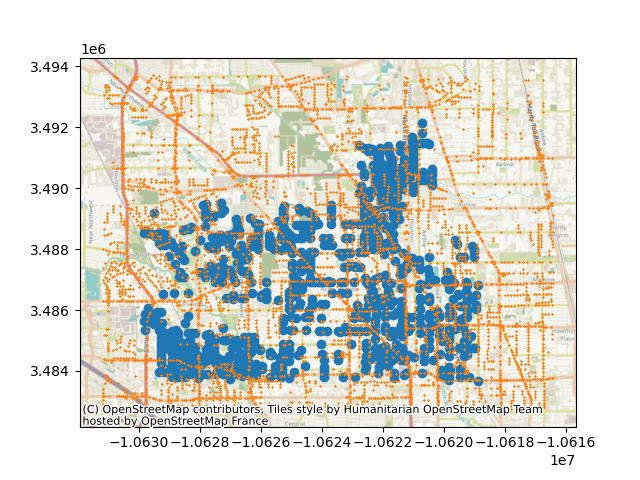

In [24]:
fig, ax = plt.subplots()
im_corner_gdf.plot(ax=ax)
corners_curr.plot(ax=ax, marker='x', markersize=0.5)
cx.add_basemap(ax=ax)

In [ ]:

    # DO WE NEED TO ADJUST THIS? 
if False: # len(tile_dirs) > 1:
    for i, tile_dir in enumerate(tile_dirs):
        ind_dir = os.path.join(registration_dir, "IndividualAdjustments")
        os.makedirs(ind_dir, exist_ok=True)

        # GET CURRENT DETECTIONS AND ADJUST
        im_corner_gdf_ind = im_corner_gdf_adj[im_corner_gdf_adj["source_image"] == tile_dir]
        print(f"INDIVIDUAL ADJUSTMENT ON {im_corner_gdf_ind.shape[0]} POINTS")
        if im_corner_gdf_ind.shape[0] == 0:
            print("CANNOT CONTINUE - NO INDIVIDUAL POINTS")
            continue
        im_corner_arry_ind  = np.stack(im_corner_gdf_ind.geometry.apply(lambda point: np.array([point.x, point.y])))

        # REGISTER FIRST PASS
        im_corner_gdf_adj_ind, registration_struct_ind = registerImagesV3(os.path.basename(tile_dir).split(".")[0],  
                    im_corner_gdf_ind, corners_curr, im_corner_arry_ind, descriptor_kwds, **adjustment_kwds)
        
        image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj_ind)

        transform = image_transform_dict.get(tile_dir)
        if transform is None:
            print(f"No transform found for {tile_name}, skipping.")
        
        # FINALIZE TRANSFORM AND EXPORT RASTER
        transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
        try:
            with rio.open(f"{ind_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()   